In [1]:
import os
os.environ['AEON_DEPRECATION_WARNING'] = 'False'

import os
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 100)

import fnmatch

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy import stats

import sys
sys.path.append("../")

from aeon.visualisation import plot_critical_difference

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
path = "TLB_logs/"
files = [
    "pp_all_sofa_bench_16_2-07-11-24-no_norm.csv",
    "pp_all_sofa_bench_16_4-07-11-24-no_norm.csv",
    "pp_all_sofa_bench_16_8-07-11-24-no_norm.csv",
    "pp_all_sofa_bench_16_16-07-11-24-no_norm.csv",
    "pp_all_sofa_bench_16_32-07-11-24-no_norm.csv",
    "pp_all_sofa_bench_16_64-07-11-24-no_norm.csv",
    "pp_all_sofa_bench_16_128-07-11-24-no_norm.csv",
    "pp_all_sofa_bench_16_256-07-11-24-no_norm.csv"
]

configs = [2, 4, 8, 16, 32, 64, 128, 256]
df_all = pd.DataFrame()
for i, file in enumerate(files):
    df = pd.read_csv(path + file)
    
    mapping = {"sfa_equi-depth_False": "SFA Equi-Depth", # + str(configs[i]),
               "sfa_equi-depth_True": "SFA Equi-Depth +Variance", # + str(configs[i]),
               "sfa_equi-width_False": "SFA Equi-Width", # + str(configs[i]),
               "sfa_equi-width_True": "SFA Equi-Width +Variance", # + str(configs[i]),
               "isax": "iSAX",
               }
    
    for key in mapping:
        df.Method = df.Method.replace({key: mapping[key]})
    
    df["Config"] = configs[i]    
    df_all = pd.concat([df_all, df])        

df = df_all
df = df.infer_objects()
display(df)

,Method,Dataset,Pruning_Power,Config
0,iSAX,ASTRO,0.428863,2
1,SFA Equi-Width +Variance,ASTRO,0.492627,2
2,SFA Equi-Width,ASTRO,0.501721,2
3,SFA Equi-Depth +Variance,ASTRO,0.495620,2
4,SFA Equi-Depth,ASTRO,0.499262,2
...,...,...,...,...
80,iSAX,TXED,0.118919,256
81,SFA Equi-Width +Variance,TXED,0.242032,256
82,SFA Equi-Width,TXED,0.172181,256
83,SFA Equi-Depth +Variance,TXED,0.234283,256


In [3]:
df = df.sort_values(by=["Dataset", "Config"])

df_normed = df.groupby(["Dataset", "Config"]) \
            .apply(lambda l: l["Pruning_Power"] / ((l["Pruning_Power"].iloc[0]))).reset_index()
    
#df_factor = df.groupby(["Dataset", "Config"]) \
#            .apply(lambda l: (l["Pruning_Power"].iloc[0]) / l["Pruning_Power"]).reset_index()

df2 = df.copy().reset_index(drop=True)
df2["factor"] = df_normed["Pruning_Power"]

df_sub = df2.reset_index()[(df2.Method == "SFA Equi-Width +Variance") & (df2.Config==2)].sort_values("factor",ascending=False)
display(df_sub)
# sns.lineplot(x="Dataset", y="factor", hue="Method", data=df_sub, sort=True)

,index,Method,Dataset,Pruning_Power,Config,factor
401,401,SFA Equi-Width +Variance,OBST2024,0.003367,2,inf
561,561,SFA Equi-Width +Variance,SIFT1B,0.430927,2,21.927874
641,641,SFA Equi-Width +Variance,TXED,0.022467,2,5.465312
521,521,SFA Equi-Width +Variance,SCEDC,0.704866,2,2.658522
41,41,SFA Equi-Width +Variance,BIGANN,0.111092,2,2.000966
481,481,SFA Equi-Width +Variance,SALD,0.321344,2,1.562810
1,1,SFA Equi-Width +Variance,ASTRO,0.492627,2,1.148682
201,201,SFA Equi-Width +Variance,Iquique,0.135215,2,1.095070
81,81,SFA Equi-Width +Variance,DEEP1B,0.368817,2,1.086358
601,601,SFA Equi-Width +Variance,STEAD,0.020597,2,1.043129


In [4]:
# df2[(df2.Method == "iSAX") & (df2.Config==2)].sort_values("factor")

In [5]:
#df[["Method", "Pruning_Power", "Config"]] \
#        .groupby(["Method", "Config"]).median() \
#        .sort_values(by=["Config", "Method"], ascending=True)

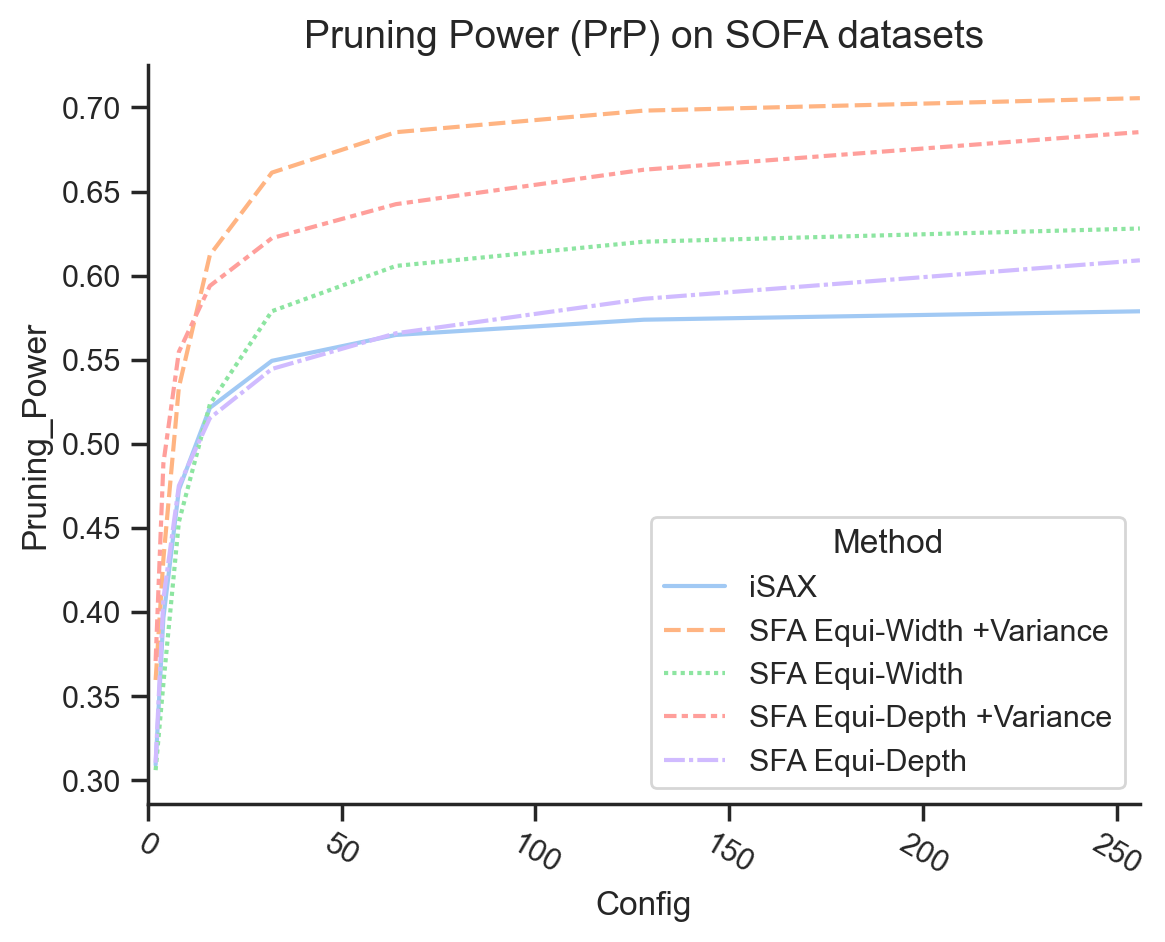

In [6]:
df["To Search"] = 1-df["Pruning_Power"]
sns.set_theme(style="ticks", palette="pastel")

ax = sns.lineplot(
    x="Config", y="Pruning_Power", hue="Method", style="Method", data=df, err_style="bars", errorbar=("se", 0)    
)
ax.set_title("Pruning Power (PrP) on SOFA datasets", fontsize=14)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)
ax.set_xlim([0,256])
sns.despine()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()
# plt.tight_layout()
plt.savefig("images/pp_sofa_boxplot.pdf", bbox_inches='tight')

In [7]:
#df[["Config", "Method", "TLB"]] \
#        .groupby(["Config", "Method"]).median() \
#        .sort_values(by=["Config", "TLB"], ascending=False).reset_index()[["Config", "Method"]]

In [8]:
df_sub = df#[df.Method.isin(["SFA Equi-Width +Variance", "SFA Equi-Width", "iSAX"])]
result = df_sub[["Config", "Method", "Pruning_Power"]] \
        .groupby(["Config", "Method"]).mean() \
        .pivot_table(columns="Config", index="Method")

result

Pruning_Power                                \
Config                             2         4         8         16    
Method                                                                 
SFA Equi-Depth                0.310473  0.407842  0.475151  0.515337   
SFA Equi-Depth +Variance      0.370949  0.488340  0.554754  0.593925   
SFA Equi-Width                0.306074  0.357440  0.453601  0.523545   
SFA Equi-Width +Variance      0.359666  0.431488  0.533682  0.612280   
iSAX                          0.309277  0.396646  0.472797  0.521446   

                                                                  
Config                         32        64        128       256  
Method                                                            
SFA Equi-Depth            0.544554  0.565757  0.586240  0.609126  
SFA Equi-Depth +Variance  0.622290  0.642500  0.662973  0.685362  
SFA Equi-Width            0.578878  0.605792  0.620183  0.628037  
SFA Equi-Width +Variance  0.661247  0.685287  0.698103  0.705521  
iSAX                      0.549377  0.564766  0.573827  0.578822

In [9]:
print(result.to_markdown())

| Method                   |   ('Pruning_Power', 2) |   ('Pruning_Power', 4) |   ('Pruning_Power', 8) |   ('Pruning_Power', 16) |   ('Pruning_Power', 32) |   ('Pruning_Power', 64) |   ('Pruning_Power', 128) |   ('Pruning_Power', 256) |
|:-------------------------|-----------------------:|-----------------------:|-----------------------:|------------------------:|------------------------:|------------------------:|-------------------------:|-------------------------:|
| SFA Equi-Depth           |               0.310473 |               0.407842 |               0.475151 |                0.515337 |                0.544554 |                0.565757 |                 0.58624  |                 0.609126 |
| SFA Equi-Depth +Variance |               0.370949 |               0.48834  |               0.554754 |                0.593925 |                0.62229  |                0.6425   |                 0.662973 |                 0.685362 |
| SFA Equi-Width           |               0.306074 |   

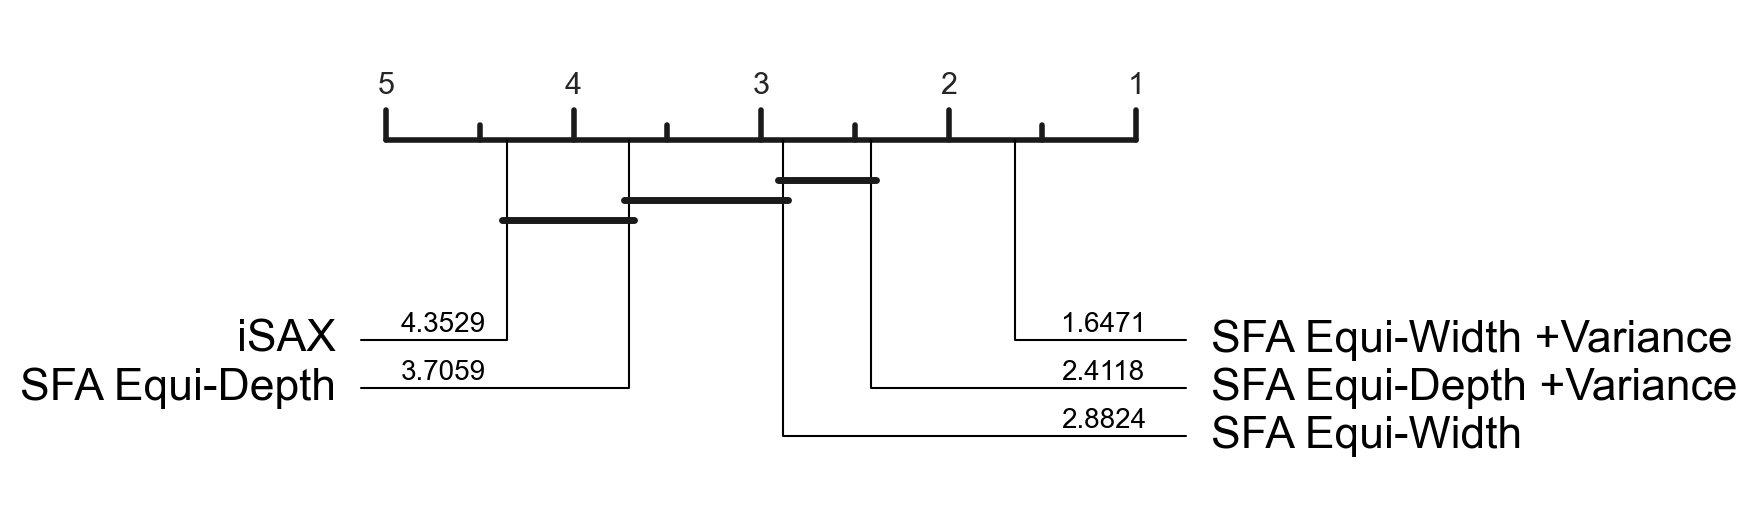

In [11]:
df_pivot = df[df.Config==256].pivot(index='Dataset', columns='Method', values='Pruning_Power')
ax = plot_critical_difference(
    scores=df_pivot.to_numpy(),
    labels=df_pivot.columns.to_numpy(),
    #errors=False,
    #clique_method="holm",
    alpha=0.05,
)
#plt.tight_layout()
plt.savefig("images/pp_SOFA_cd_diagramm.pdf", bbox_inches='tight')